## Analyses (EEG)

In [40]:
# imports
import numpy as np
import pandas as pd; pd.set_option('display.max_columns', None)
import cmlreaders as cml
from tqdm.notebook import tqdm
import itertools
from ptsa.data.filters import morlet
from ptsa.data.filters import ButterworthFilter
import os
from glob import glob
import scipy.stats

#### Load in Results (and Errors)

In [10]:
# load and concatenate from temp directories, save out
def load_eeg_results_errors():
    # results
    nse_data = []
    res_csvs = [x for x in os.listdir('analyses/temp/dataframes/') if x[-3:] == 'csv']
    for csv in res_csvs:
        nse_data.append(pd.read_csv(f'analyses/temp/dataframes/{csv}'))

    nse_data = pd.concat(nse_data, ignore_index=True)
    nse_data.to_csv('analyses/dataframes/nse_data.csv', index=False)
    
    # errors
    nse_errors = []
    err_csvs = [x for x in os.listdir('analyses/temp/errors/') if x[-3:] == 'csv']
    for csv in err_csvs:
        nse_errors.append(pd.read_csv(f'analyses/temp/errors/{csv}'))

    nse_errors = pd.concat(nse_errors, ignore_index=True)
    nse_errors.to_csv('analyses/dataframes/nse_errors.csv', index=False)
    
    return nse_data, nse_errors

In [11]:
nse_data, nse_errors = load_eeg_results_errors()

#### Calculate Neural Drift at Encoding

El-Kalliny (2014): `neural_drift` = (p1 - p2) / p1

In [31]:
def calculate_neural_drift_encoding(nse_data):
    nde_data = []
    for (sub, et, exp, sess, loc, mont, l), data in tqdm(nse_data.groupby(['subject', 'exp_type', 'experiment', 'session', 'localization', 'montage', 'list'])):
        nde = data.groupby('serial_distance')['cosine_similarity'].mean()
        p1 = nde.loc[1]
        p2 = nde.loc[2]
        nd = (p1 - p2) / p1

        nde_data.append((sub, et, exp, sess, loc, mont, l, nd))

    # save results as dataframe
    nde_data = pd.DataFrame(nde_data, columns=['subject', 'exp_type', 'experiment', 'session', 'localization', 'montage', 'list', 'neural_drift'])
    
    return nde_data

def nde_btwn_subj_avg(nde_data):
    nde_data_bsa = nde_data.groupby(['subject', 'exp_type', 'experiment'])['neural_drift'].mean().reset_index()
    
    return nde_data_bsa

In [30]:
nde_data = calculate_neural_drift_encoding(nse_data)
nde_data.to_csv('analyses/dataframes/nde_data.csv', index=False)

  0%|          | 0/70670 [00:00<?, ?it/s]

In [28]:
# between-subject average
nde_data_bsa = nde_data.groupby(['subject', 'exp_type', 'experiment'])['neural_drift'].mean().reset_index()
nde_data_bsa

,subject,exp_type,experiment,neural_drift
0,BW022,intracranial,pyFR,0.221697
1,BW023,intracranial,pyFR,0.255409
2,BW024,intracranial,pyFR,-0.081930
3,LTP093,scalp,ltpFR2,0.086846
4,LTP106,scalp,ltpFR2,-0.189067
...,...,...,...,...
515,UP042,intracranial,pyFR,0.343848
516,UP043,intracranial,pyFR,0.427339
517,UP044,intracranial,pyFR,0.213562
518,UP045,intracranial,pyFR,0.355234


#### Correlations with Neural Drift at Encoding

In [34]:
pcs_v1_data = pd.read_csv('analyses/dataframes/pcs_v1_data.csv')
pcs_v2_data = pd.read_csv('analyses/dataframes/pcs_v2_data.csv')
tcs_data = pd.read_csv('analyses/dataframes/tcs_data.csv')
scs_data = pd.read_csv('analyses/dataframes/scs_data.csv')
p_recall_data = pd.read_csv('analyses/dataframes/p_recall_data.csv')

In [44]:
def aggregate_data(pcs_v1_data, pcs_v2_data, tcs_data, scs_data, p_recall_data, nde_data):
    id_cols = ['subject', 'exp_type', 'experiment', 'session', 'localization', 'montage', 'list']
    # pcs v1 & pcs v2
    df = pd.merge(pcs_v1_data, pcs_v2_data, on=id_cols, how='inner', suffixes=('_v1', '_v2'))
    df = df.drop_duplicates(subset=id_cols, keep=False)
    
    # tcs
    df = pd.merge(df, tcs_data, on=id_cols, how='inner')
    df = df.drop_duplicates(subset=id_cols, keep=False)

    # scs
    df = pd.merge(df, scs_data, on=id_cols, how='inner')
    df = df.drop_duplicates(subset=id_cols, keep=False)

    # p_recall
    df = pd.merge(df, p_recall_data, on=id_cols, how='inner')
    df = df.drop_duplicates(subset=id_cols, keep=False)
    
    # neural drift at encoding
    df = pd.merge(df, nde_data, on=id_cols, how='inner')
    df = df.drop_duplicates(subset=id_cols, keep=False)
    
    # remove any NaN
    df = df.dropna()
    
    return df

In [45]:
df = aggregate_data(pcs_v1_data, pcs_v2_data, tcs_data, scs_data, p_recall_data, nde_data)

In [56]:
# correlate with neural drift over lists within session
def nde_correlations(df):
    stats = []
    for (sub, et, exp, sess, loc, mont), data in tqdm(df.groupby(['subject', 'exp_type', 'experiment', 'session', 'localization', 'montage'])):
        if len(data) > 1:
            # correlations with nde
            r_pcs_v1, _ = scipy.stats.pearsonr(data.neural_drift, data.pcs_v1, alternative='two-sided')
            r_pcs_v2, _ = scipy.stats.pearsonr(data.neural_drift, data.pcs_v2, alternative='two-sided')
            r_tcs, _ = scipy.stats.pearsonr(data.neural_drift, data.tcs, alternative='two-sided')
            r_scs, _ = scipy.stats.pearsonr(data.neural_drift, data.scs, alternative='two-sided')
            r_p_recall, _ = scipy.stats.pearsonr(data.neural_drift, data.p_recall, alternative='two-sided')
            
            stats.append((sub, et, exp, sess, loc, mont, r_pcs_v1, r_pcs_v2, r_tcs, r_scs, r_p_recall))
            
    # save results as dataframe
    return pd.DataFrame(stats, columns=['subject', 'exp_type', 'experiment', 'session', 'localization', 'montage',
                                        'r_pcs_v1', 'r_pcs_v2', 'r_tcs', 'r_scs', 'r_p_recall'])

# neural drift correlations between-subject average
def nde_corr_btwn_subj_avg(nde_corrs):
    nde_corrs_bsa = nde_corrs.groupby(['subject', 'exp_type', 'experiment'])[['r_pcs_v1', 'r_pcs_v2', 'r_tcs', 'r_scs', 'r_p_recall']].mean().reset_index()
    
    return nde_corrs_bsa

In [57]:
nde_corrs = nde_correlations(df)

  0%|          | 0/3169 [00:00<?, ?it/s]

/tmp/ipykernel_13789/2394476077.py:11: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_p_recall, _ = scipy.stats.pearsonr(data.neural_drift, data.p_recall, alternative='two-sided')
/tmp/ipykernel_13789/2394476077.py:7: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_pcs_v1, _ = scipy.stats.pearsonr(data.neural_drift, data.pcs_v1, alternative='two-sided')
/tmp/ipykernel_13789/2394476077.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_tcs, _ = scipy.stats.pearsonr(data.neural_drift, data.tcs, alternative='two-sided')


In [58]:
nde_corrs_bsa = nde_corr_btwn_subj_avg(nde_corrs)

In [59]:
nde_corrs_bsa.groupby(['exp_type'])[['r_pcs_v1', 'r_pcs_v2', 'r_tcs', 'r_scs', 'r_p_recall']].mean().reset_index()

,exp_type,r_pcs_v1,r_pcs_v2,r_tcs,r_scs,r_p_recall
0,intracranial,0.006991,0.007391,-0.036245,0.015675,-0.017925
1,scalp,0.006906,0.010253,0.013481,-0.002821,-0.030459


In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

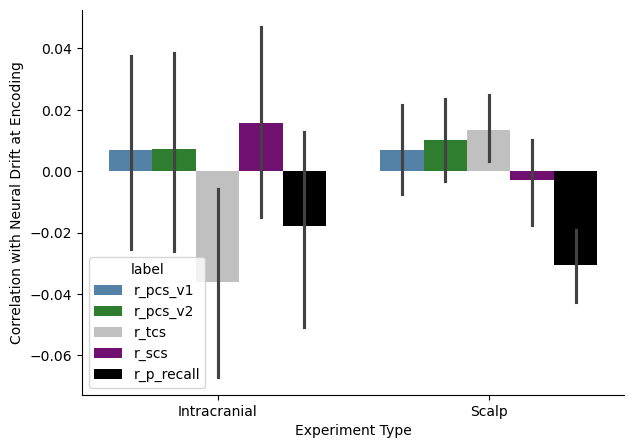

In [61]:
dfm = pd.melt(nde_corrs_bsa, id_vars=['subject', 'exp_type', 'experiment'], 
              value_vars=['r_pcs_v1', 'r_pcs_v2', 'r_tcs', 'r_scs', 'r_p_recall'],
              var_name='label', value_name='correlation')

fig, ax = plt.subplots(figsize=(7, 5))

sns.barplot(dfm, x='exp_type', y='correlation', order=['intracranial', 'scalp'],
            hue='label', hue_order=['r_pcs_v1', 'r_pcs_v2', 'r_tcs', 'r_scs', 'r_p_recall'],
            palette=['steelblue', 'forestgreen', 'silver', 'purple', 'black'], ax=ax)

ax.spines[['right', 'top']].set_visible(False)
ax.set(xlabel='Experiment Type', ylabel='Correlation with Neural Drift at Encoding')
ax.set_xticks([0, 1], labels=['Intracranial', 'Scalp'])

plt.show()

In [ ]:
stats_final = []
for et, data in nde_corrs_bsa.groupby('exp_type'):
    if len(data) > 1:
        res = scipy.stats.